В базе данных нефтегазовых месторождений одной компании произошёл системный сбой и информация о типе месторождения по расположению (на берегу или в открытом море) была удалена. Так как эта информация крайне важна, вам необходимо восстановить её в пострадавшем датасете

Входные данные: тренировочный датасет train.csv, в котором поля обозначают следующее:

Tectonic regime – тектонический режим месторождения  
Onshore/Oﬀshore – тип месторождения по расположению  
Hydrocarbon type – тип углеводородов  
Reservoir status – статус разработки месторождения  
Structural setting – структурные особенности месторождения  
Depth – средняя глубина кровли резервуара  
Period – геологическая система образования резервуара  
Lithology – основной литологический состав коллектора  
Gross – среднее значение общей толщины резервуара  
Netpay – среднее значение эффективной углеводородонасыщенной толщины коллектора  
Porosity – среднее значение матричной пористости  
Permeability – среднее значение проницаемости по воздуху.  

test.csv – датасет, для которого необходимо предсказать поле «Onshore/Oﬀshore»

Выходные данные: файл prediction.csv, в котором одна колонка (без заголовка) с предсказанием поля Onshore/Oﬀshore. Предсказания следует выводить в тех же значениях, в каких они представлены в тренировочном датасете (ONSHORE/OFFSHORE/ ONSHORE-OFFSHORE).

Критерии проверки: вычисляется точность предсказания (accuracy_score), округляется до 2-х знаков и итоговый балл считается по формуле score = 50*accuracy_score. Таким образом максимальный балл 50 будет соответствовать максимально точности 1.

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
%matplotlib inline
pd.set_option('max_colwidth', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Data proccessing

In [2]:
train_df = pd.read_csv("data/train.csv")
X_test = pd.read_csv("data/test.csv")

train_df.columns = (train_df.columns.str.strip()
                            .str.replace('\s+', '_', regex=True)
                            .str.replace('/', '_', regex=True))
X_test.columns = (X_test.columns.str.strip()
                            .str.replace('\s+', '_', regex=True)
                            .str.replace('/', '_', regex=True))

In [3]:
num_cols = ["Depth", "Gross", "Netpay", "Porosity", "Permeability"]
cat_cols = ["Tectonic_regime", "Hydrocarbon_type", "Reservoir_status", "Structural_setting", "Period", "Lithology"]
feature_cols = num_cols + cat_cols
target_col = "Onshore_Offshore"

In [4]:
train_df.head()

,Tectonic_regime,Onshore_Offshore,Hydrocarbon_type,Reservoir_status,Structural_setting,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability
0,STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,OFFSHORE,OIL,DEVELOPING,INVERSION/WRENCH,3520,NEOGENE,SANDSTONE,2460.0,220.0,20.0,45.0
1,GRAVITY/EXTENSION/EVAPORITE,OFFSHORE,OIL,MATURE PRODUCTION,SALT/PASSIVE MARGIN,9967,CRETACEOUS,LIMESTONE,427.0,160.0,19.0,175.0
2,GRAVITY/EXTENSION/EVAPORITE,ONSHORE,OIL,MATURE PRODUCTION,PASSIVE MARGIN,8700,CRETACEOUS,LIMESTONE,95.0,15.0,12.0,20.0
3,COMPRESSION,ONSHORE,OIL,DECLINING PRODUCTION,THRUST,5084,CRETACEOUS,SANDSTONE,328.0,300.0,13.0,600.0
4,INVERSION/COMPRESSION/EXTENSION,ONSHORE,OIL,DECLINING PRODUCTION,INVERSION/RIFT,1030,CRETACEOUS,SANDSTONE,260.0,33.0,24.0,182.0


In [5]:
# looks on target distribution
train_df['Onshore_Offshore'].value_counts()

ONSHORE             211
OFFSHORE             93
ONSHORE-OFFSHORE      5
Name: Onshore_Offshore, dtype: int64

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode target
lbl_encoder = LabelEncoder()
train_df["Onshore_Offshore"] = lbl_encoder.fit_transform(train_df['Onshore_Offshore'])

In [7]:
# Look at train data
train_profile = ProfileReport(train_df)
train_profile.to_file("reports/train_data.html")

In [8]:
# Look at test data
test_profile = ProfileReport(X_test)
test_profile.to_file("reports/test_data.html")

# Models training

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define a dict to save models
models_dict = {'model_name': [],
               'model': [],
               'type': [],
               'threshold':[],
               'val_accuracy': [],
               }

def opt_threshold_acc(y_true, y_pred):
    A = list(zip(y_true, y_pred))
    A = sorted(A, key=lambda x: x[1])
    total = len(A)
    tp = len([1 for x in A if x[0]==1])
    tn = 0
    th_acc = []
    for x in A:
        th = x[1]
        if x[0] == 1:
            tp -= 1
        else:
            tn += 1
        acc = (tp + tn) / total
        th_acc.append((th, acc))
    return max(th_acc, key=lambda x: x[1])

def metrics_eval(y_test, y_pred):
    print('Max test accuracy_score:', accuracy_score(y_test, y_pred))
    print('classification_report:\n', classification_report(y_test, y_pred))
    df = pd.DataFrame(confusion_matrix(y_test, y_pred))
    sns.heatmap(df, annot=True, cbar=None, cmap="Blues")

def seve_best_model(models_dict, model, model_name, X_test, y_test):
    if model_name =='CatBoostClassifier':
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict_proba(X_test)

    if y_pred.shape[1] == 2:
        y_pred = y_pred[:, 1]
        threshold, accuracy = opt_threshold_acc(y_test, y_pred)
        type_ = 'binary'
        y_pred = pd.Series(y_pred).apply(lambda x: 1 if x > threshold else 0)
    elif y_pred.shape[1] > 2:
        y_pred = pd.DataFrame(y_pred.round(3).argmax(axis=1), columns=['target_pred'])
        threshold = None
        type_ = 'multiclass'
        accuracy = accuracy_score(y_test, y_pred)
    else:
        raise ValueError('model predict_proba incorrect')

    models_dict['model_name'].append(model_name)
    models_dict['model'].append(model)
    models_dict['type'].append(type_)
    models_dict['threshold'].append(threshold)
    models_dict['val_accuracy'].append(accuracy)

    metrics_eval(y_test, y_pred)

## Multiclass classification

In [10]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(train_df[feature_cols],
                                                  train_df[target_col],
                                                  stratify=train_df[target_col],
                                                  shuffle=True,
                                                  random_state=42,
                                                  train_size=0.8)

### Catboost

In [11]:
from catboost import CatBoostClassifier, Pool

In [12]:
train_pool = Pool(X_train, pd.get_dummies(y_train, drop_first=False), cat_features=cat_cols)
val_pool = Pool(X_val, pd.get_dummies(y_val, drop_first=False), cat_features=cat_cols)

In [13]:
catboost_model = CatBoostClassifier(
                loss_function='MultiCrossEntropy', # MultiCrossEntropy, MultiClassOneVsAll
                eval_metric='Accuracy',
                iterations=1000,
                learning_rate=0.01,
                l2_leaf_reg=3,
                bagging_temperature=1,
                random_strength=1,
                one_hot_max_size=2,
                leaf_estimation_method='Newton',
                save_snapshot=True,
                snapshot_file='models/snapshot.bkp',
                snapshot_interval=1,
                )
catboost_model.fit(train_pool,
                   eval_set=val_pool,
                   metric_period=10,
                   plot=False,
                   verbose=50)


bestTest = 0.8709677419
bestIteration = 460

Shrink model to first 461 iterations.


Max test accuracy_score: 0.8709677419354839
classification_report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80        19
           1       0.93      0.90      0.92        42
           2       0.00      0.00      0.00         1

    accuracy                           0.87        62
   macro avg       0.56      0.58      0.57        62
weighted avg       0.86      0.87      0.87        62



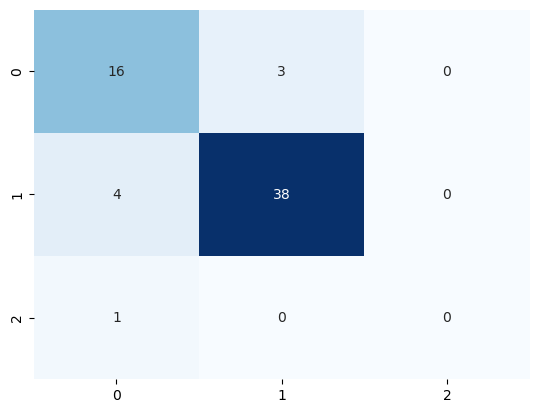

In [14]:
seve_best_model(models_dict, catboost_model, 'CatBoostClassifier' ,val_pool, y_val)

In [15]:
catboost_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Tectonic_regime,24.690609
1,Period,12.633945
2,Structural_setting,11.827578
3,Hydrocarbon_type,9.844813
4,Reservoir_status,9.086950
5,Lithology,8.322665
6,Netpay,7.138068
7,Depth,6.601521
8,Porosity,4.105780
9,Permeability,4.068825


### LogisticRegressionCV

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [17]:
# # Oversampling
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler
#
# sm = RandomOverSampler(random_state=42,
#                        sampling_strategy={1:78,0:180, 2:30}
#                       )
# und = RandomUnderSampler(random_state=42,
#                        sampling_strategy={1:78,0:180, 2:30}
#                       )

In [18]:
# Define preproccessors
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [19]:
from sklearn.linear_model import LogisticRegressionCV

fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

logit_reg_mod = LogisticRegressionCV(
    penalty="elasticnet",
    scoring='accuracy', # aug_score, recall_weighted, accuracy
    Cs=list(np.power(10.0, np.arange(-10, 10))),
    max_iter=15000,
    cv=fold,
    refit=True,
    class_weight="balanced",
    random_state=42,
    multi_class = "multinomial",
    solver='saga', # ‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}
    n_jobs=-1,
    l1_ratios=list(np.arange(0, 1, 0.2)),
    verbose=0
    )

logit_reg_mult = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", logit_reg_mod)]
)
logit_reg_mult.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Depth', 'Gross', 'Netpay',
                                                   'Porosity',
                                                   'Permeability']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Tectonic_regime',
                                                   'Hydrocarbon_type',
                                                   'Reservoir_status',
                                                   'Structural_setting',
                                                   'Period', '...
                                          1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0,
                                          10.0, 100.0, 1000.0, 10000.0,
                                          100000.0, 1000000.0, 10000000.0,
                                          100000000.0, 1000000000.0],
                                      class_weight='balanced',
                                      cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                                      l1_ratios=[0.0, 0.2, 0.4,
                                                 0.6000000000000001, 0.8],
                                      max_iter=15000, multi_class='multinomial',
                                      n_jobs=-1, penalty='elasticnet',
                                      random_state=42, scoring='accuracy',
                                      solver='saga'))])

Max test accuracy_score: 0.9032258064516129
classification_report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93        19
           1       1.00      0.86      0.92        42
           2       0.25      1.00      0.40         1

    accuracy                           0.90        62
   macro avg       0.70      0.95      0.75        62
weighted avg       0.95      0.90      0.92        62



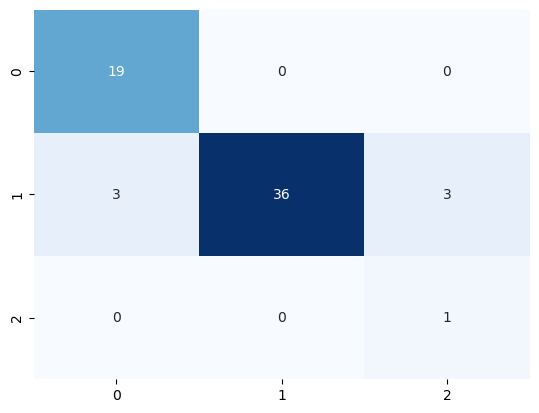

In [20]:
seve_best_model(models_dict, logit_reg_mult, 'LogisticRegressionCV', X_val, y_val)

# RandomForestClassifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
# Define preproccessors
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

rand_forest_mult = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", RandomForestClassifier())]
)

rand_forest_mult.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Depth', 'Gross', 'Netpay',
                                                   'Porosity',
                                                   'Permeability']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Tectonic_regime',
                                                   'Hydrocarbon_type',
                                                   'Reservoir_status',
                                                   'Structural_setting',
                                                   'Period', 'Lithology'])])),
                ('classifier', RandomForestClassifier())])

Max test accuracy_score: 0.8225806451612904
classification_report:
               precision    recall  f1-score   support

           0       0.76      0.68      0.72        19
           1       0.84      0.90      0.87        42
           2       0.00      0.00      0.00         1

    accuracy                           0.82        62
   macro avg       0.54      0.53      0.53        62
weighted avg       0.81      0.82      0.81        62



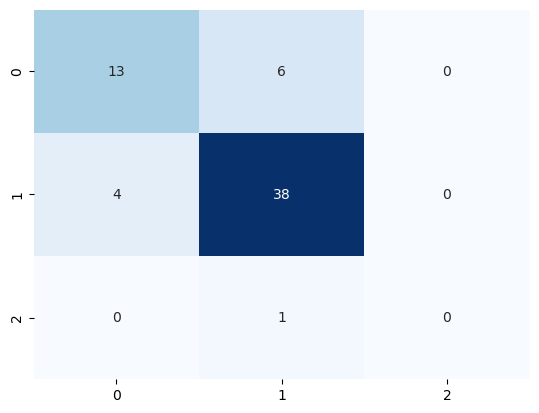

In [23]:
seve_best_model(models_dict, rand_forest_mult, 'RandomForestClassifier', X_val, y_val)

# XGBClassifier

In [24]:
# https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn

In [25]:
import xgboost as xgb

# Define preproccessors
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)


xgb_cls = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

xgb_model = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", xgb_cls)]
)

params = {
    "classifier__colsample_bytree": [0.7, 0.3],
    "classifier__gamma": [0, 0.5],
    "classifier__learning_rate": [0.1, 0.03, 0.3], # default 0.1
    "classifier__max_depth": [2, 6], # default 3
    "classifier__n_estimators": [100, 300, 500], # default 100
    "classifier__subsample": [0.6, 0.4]
}

xgb_mult = GridSearchCV(xgb_model,
                    param_grid=params,
                    cv=3,
                    verbose=1,
                    n_jobs=-1)
xgb_mult.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Depth',
                                                                          'Gross',
                                                                          'Netpay',
                                                                          'Porosity',
                                                                          'Permeability']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Tectonic_regime',
                                                                          'Hydrocarbon_type',
                                                                          'Reservoir_status',
                                                                          'St...
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      objective='multi:softprob',
                                                      predictor=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.7, 0.3],
                         'classifier__gamma': [0, 0.5],
                         'classifier__learning_rate': [0.1, 0.03, 0.3],
                         'classifier__max_depth': [2, 6],
                         'classifier__n_estimators': [100, 300, 500],
                         'classifier__subsample': [0.6, 0.4]},
             verbose=1)

Max test accuracy_score: 0.8064516129032258
classification_report:
               precision    recall  f1-score   support

           0       0.67      0.74      0.70        19
           1       0.88      0.86      0.87        42
           2       0.00      0.00      0.00         1

    accuracy                           0.81        62
   macro avg       0.51      0.53      0.52        62
weighted avg       0.80      0.81      0.80        62



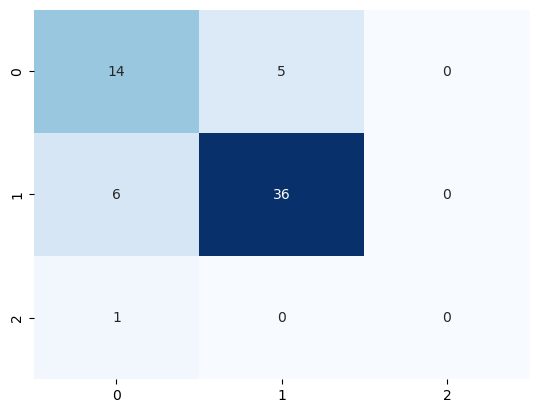

In [26]:
seve_best_model(models_dict, xgb_mult, 'XGBClassifier', X_val, y_val)

# Binary classification without last class

may be it gets us overall higher score

# Drop last class

In [27]:
# Drop last class
train_df_bin = train_df[train_df["Onshore_Offshore"] != 2].reset_index(drop=True)
minor_class = train_df[train_df["Onshore_Offshore"] == 2]

In [28]:
X_train, X_val, y_train, y_val = train_test_split(train_df_bin[feature_cols],
                                                  train_df_bin[target_col],
                                                  stratify=train_df_bin[target_col],
                                                  shuffle=True,
                                                  random_state=42,
                                                  train_size=0.8)
# Add minor class in test
X_val = pd.concat([X_val, minor_class[feature_cols]], axis=0)
y_val = pd.concat([y_val, minor_class[target_col]], axis=0)

### XGBClassifier

In [29]:
import xgboost as xgb

# Define preproccessors
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)


xgb_cls = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

xgb_model = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", xgb_cls)]
)

params = {
    "classifier__colsample_bytree": [0.7, 0.3],
    "classifier__gamma": [0, 0.5],
    "classifier__learning_rate": [0.1, 0.03, 0.3], # default 0.1
    "classifier__max_depth": [2, 6], # default 3
    "classifier__n_estimators": [100, 300, 500], # default 100
    "classifier__subsample": [0.6, 0.4]
}

search_xgb = GridSearchCV(xgb_model,
                    param_grid=params,
                    cv=3,
                    verbose=1,
                    n_jobs=-1)

search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Depth',
                                                                          'Gross',
                                                                          'Netpay',
                                                                          'Porosity',
                                                                          'Permeability']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Tectonic_regime',
                                                                          'Hydrocarbon_type',
                                                                          'Reservoir_status',
                                                                          'St...
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.7, 0.3],
                         'classifier__gamma': [0, 0.5],
                         'classifier__learning_rate': [0.1, 0.03, 0.3],
                         'classifier__max_depth': [2, 6],
                         'classifier__n_estimators': [100, 300, 500],
                         'classifier__subsample': [0.6, 0.4]},
             verbose=1)

Max test accuracy_score: 0.803030303030303
classification_report:
               precision    recall  f1-score   support

           0       0.64      0.95      0.77        19
           1       0.92      0.83      0.88        42
           2       0.00      0.00      0.00         5

    accuracy                           0.80        66
   macro avg       0.52      0.59      0.55        66
weighted avg       0.77      0.80      0.78        66



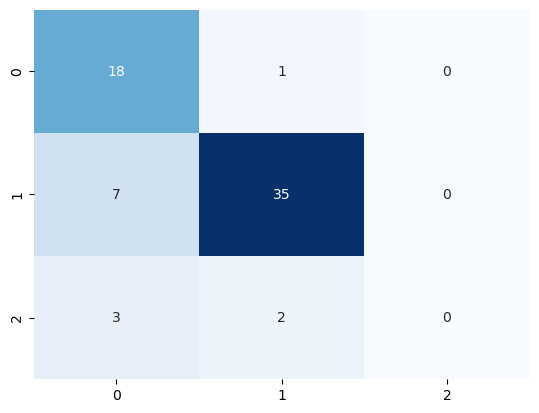

In [30]:
seve_best_model(models_dict, search_xgb, 'XGBClassifier', X_val, y_val)

### LogisticRegressionCV

In [31]:
# Define preproccessors
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

log_reg = LogisticRegressionCV(
    penalty="l2",
    scoring='accuracy', # aug_score, recall_weighted, accuracy
    Cs=list(np.power(10.0, np.arange(-10, 10))),
    n_jobs=-1,
    max_iter=15000,
    cv=fold,
    refit=True,
    class_weight="balanced",
    random_state=42
    )


logit_reg = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", log_reg)]
)



logit_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Depth', 'Gross', 'Netpay',
                                                   'Porosity',
                                                   'Permeability']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Tectonic_regime',
                                                   'Hydrocarbon_type',
                                                   'Reservoir_status',
                                                   'Structural_setting',
                                                   'Period', 'Lithology'])])),
                ('classifier',
                 LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06,
                                          1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0,
                                          10.0, 100.0, 1000.0, 10000.0,
                                          100000.0, 1000000.0, 10000000.0,
                                          100000000.0, 1000000000.0],
                                      class_weight='balanced',
                                      cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                                      max_iter=15000, n_jobs=-1,
                                      random_state=42, scoring='accuracy'))])

Max test accuracy_score: 0.8787878787878788
classification_report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89        19
           1       0.87      0.98      0.92        42
           2       0.00      0.00      0.00         5

    accuracy                           0.88        66
   macro avg       0.59      0.62      0.61        66
weighted avg       0.81      0.88      0.84        66



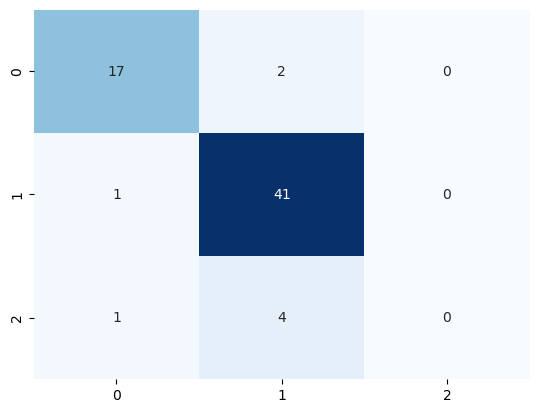

In [32]:
seve_best_model(models_dict, logit_reg, 'LogisticRegressionCV', X_val, y_val)

In [33]:
# import pickle
# with open("models/log_reg.pickle", "wb") as record_file:
#     record_file = pickle.dumps(logit_reg)

In [34]:
# import pickle
# with open("models/log_reg.pickle", "rb") as read_file:
#     best_log_reg = pickle.load(read_file)
# metrics_eval(best_log_reg, X_test, y_test)

### RandomForestClassifier

In [37]:
from sklearn.ensemble import RandomForestClassifier

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

rand_forest = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", RandomForestClassifier())]
)


rf_params = {
        "classifier__max_depth": [None],
        "classifier__max_features": [1, 2],
        "classifier__min_samples_split": [2, 3, 10],
        "classifier__min_samples_leaf": [1, 3, 10],
        "classifier__bootstrap": [False],
        "classifier__n_estimators": [300, 500],
        "classifier__criterion": ["gini","entropy"],
        "classifier__class_weight":["balanced"]
    }

kfold = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
random_forest_model = GridSearchCV(rand_forest,
                    param_grid=rf_params,
                    cv=kfold,
                    n_jobs=-1,
                    scoring="accuracy",
                    verbose=1,
                    )

random_forest_model.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Depth',
                                                                          'Gross',
                                                                          'Netpay',
                                                                          'Porosity',
                                                                          'Permeability']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Tec...
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [False],
                         'classifier__class_weight': ['balanced'],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None],
                         'classifier__max_features': [1, 2],
                         'classifier__min_samples_leaf': [1, 3, 10],
                         'classifier__min_samples_split': [2, 3, 10],
                         'classifier__n_estimators': [300, 500]},
             scoring='accuracy', verbose=1)

Max test accuracy_score: 0.8484848484848485
classification_report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.83        19
           1       0.95      0.88      0.91        42
           2       0.00      0.00      0.00         5

    accuracy                           0.85        66
   macro avg       0.55      0.63      0.58        66
weighted avg       0.81      0.85      0.82        66



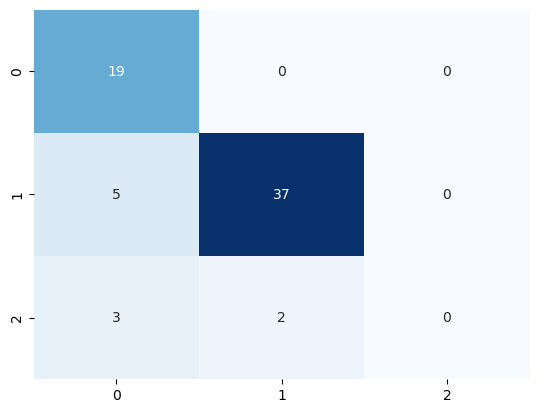

In [38]:
seve_best_model(models_dict, random_forest_model, 'RandomForestClassifier', X_val, y_val)

### GradientBoostingClassifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

gb_cls = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", GradientBoostingClassifier())]
)

gb_params = {
        'classifier__loss' : ["log_loss"],
        'classifier__n_estimators' : [100, 200, 300],
        'classifier__learning_rate': [0.1, 0.05, 0.01],
        'classifier__max_depth': [4, 8],
        'classifier__min_samples_leaf': [100, 150],
        'classifier__max_features': [0.3, 0.1]}

kfold = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
gb_model = GridSearchCV(gb_cls,
                    param_grid=gb_params,
                    cv=kfold,
                    n_jobs=-1,
                    scoring="accuracy",
                    verbose=1,
                    )

gb_model.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Depth',
                                                                          'Gross',
                                                                          'Netpay',
                                                                          'Porosity',
                                                                          'Permeability']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Tec...
                                                                          'Structural_setting',
                                                                          'Period',
                                                                          'Lithology'])])),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.1, 0.05, 0.01],
                         'classifier__loss': ['log_loss'],
                         'classifier__max_depth': [4, 8],
                         'classifier__max_features': [0.3, 0.1],
                         'classifier__min_samples_leaf': [100, 150],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

Max test accuracy_score: 0.7272727272727273
classification_report:
               precision    recall  f1-score   support

           0       0.53      0.95      0.68        19
           1       0.94      0.71      0.81        42
           2       0.00      0.00      0.00         5

    accuracy                           0.73        66
   macro avg       0.49      0.55      0.50        66
weighted avg       0.75      0.73      0.71        66



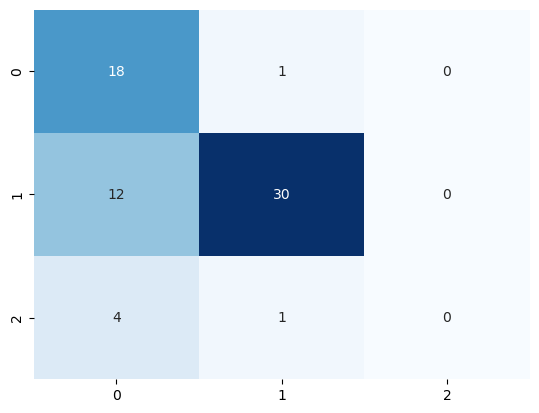

In [40]:
seve_best_model(models_dict, gb_model, 'GradientBoostingClassifier', X_val, y_val)

### MLPClassifier

In [41]:
from sklearn.neural_network import MLPClassifier

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

mlp_cls = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", MLPClassifier())]
)


mlp_params = {
        'classifier__hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), 100],
        'classifier__activation': ['tanh', 'relu'],
        'classifier__solver': ['sgd', 'adam'],
        'classifier__alpha': [0.0001, 0.05],
        'classifier__learning_rate': ['constant', 'adaptive'],
        'classifier__max_iter': [400],
        'classifier__early_stopping': [True]}

kfold = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
mlp_model = GridSearchCV(mlp_cls,
                    param_grid=mlp_params,
                    cv=kfold,
                    n_jobs=-1,
                    scoring="accuracy",
                    verbose=1,
                    )
mlp_model.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Depth',
                                                                          'Gross',
                                                                          'Netpay',
                                                                          'Porosity',
                                                                          'Permeability']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Tec...
                                       ('classifier', MLPClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__activation': ['tanh', 'relu'],
                         'classifier__alpha': [0.0001, 0.05],
                         'classifier__early_stopping': [True],
                         'classifier__hidden_layer_sizes': [(50, 50, 50),
                                                            (50, 100, 50),
                                                            100],
                         'classifier__learning_rate': ['constant', 'adaptive'],
                         'classifier__max_iter': [400],
                         'classifier__solver': ['sgd', 'adam']},
             scoring='accuracy', verbose=1)

Max test accuracy_score: 0.8333333333333334
classification_report:
               precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.89      0.93      0.91        42
           2       0.00      0.00      0.00         5

    accuracy                           0.83        66
   macro avg       0.54      0.59      0.56        66
weighted avg       0.77      0.83      0.80        66



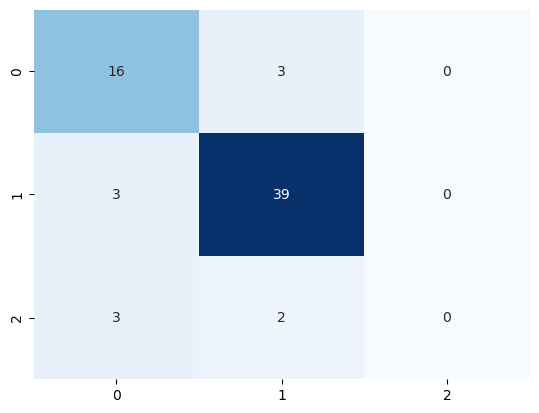

In [42]:
seve_best_model(models_dict, mlp_model, 'MLPClassifier', X_val, y_val)

# Write best model prediction to file

In [43]:
models_df = pd.DataFrame(models_dict).sort_values('val_accuracy')
models_df

,model_name,model,type,threshold,val_accuracy
7,GradientBoostingClassifier,"GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),\n estimator=Pipeline(steps=[('preprocessor',\n ColumnTransformer(tran...",binary,0.659054,0.787879
3,XGBClassifier,"GridSearchCV(cv=3,\n estimator=Pipeline(steps=[('preprocessor',\n ColumnTransformer(transformers=[('num',\n ...",multiclass,NaN,0.806452
2,RandomForestClassifier,"(ColumnTransformer(transformers=[('num',\n Pipeline(steps=[('imputer',\n SimpleImputer(strategy='median')),\n ...",multiclass,NaN,0.822581
4,XGBClassifier,"GridSearchCV(cv=3,\n estimator=Pipeline(steps=[('preprocessor',\n ColumnTransformer(transformers=[('num',\n ...",binary,0.658898,0.848485
0,CatBoostClassifier,<catboost.core.CatBoostClassifier object at 0x7f7fad5484c0>,multiclass,NaN,0.870968
8,MLPClassifier,"GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),\n estimator=Pipeline(steps=[('preprocessor',\n ColumnTransformer(tran...",binary,0.658468,0.878788
5,LogisticRegressionCV,"(ColumnTransformer(transformers=[('num',\n Pipeline(steps=[('imputer',\n SimpleImputer(strategy='median')),\n ...",binary,0.153357,0.893939
6,RandomForestClassifier,"GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),\n estimator=Pipeline(steps=[('preprocessor',\n ColumnTransformer(tran...",binary,0.637860,0.893939
1,LogisticRegressionCV,"(ColumnTransformer(transformers=[('num',\n Pipeline(steps=[('imputer',\n SimpleImputer(strategy='median')),\n ...",multiclass,NaN,0.903226


In [44]:
best_model = models_df.iloc[-1]

if best_model['model_name'] =='CatBoostClassifier':
    y_pred = best_model['model'].predict(Pool(X_test, cat_features=cat_cols))
else:
    y_pred = best_model['model'].predict_proba(X_test)

if y_pred.shape[1] == 2:
    y_pred = pd.Series(y_pred[:, 1]).apply(lambda x: 1 if x > best_model['threshold'] else 0)
elif y_pred.shape[1] > 2:
    y_pred = pd.DataFrame(y_pred.round(3).argmax(axis=1), columns=['target_pred'])

In [45]:
res_df = pd.DataFrame(lbl_encoder.inverse_transform(y_pred))
res_df.to_csv("outputs/prediction__.csv", header=False, index=False)